# **Animal Species Classification using CNN**

Author: Shreya Ganjoo 

Last updated: 04-06-2023

## **Metadata of the dataset**

The dataset link is - 

1) [Animal Species](https://drive.google.com/drive/folders/1O16B5DZ5SR1Fa_3HHv6NH2_kdcQL059p?usp=sharing) 

2) [Animal Species Kaggle](https://www.kaggle.com/datasets/shreyaganjoo/animalspecies) 

The dataset has 4 species of animals mainly - 'Elephant', 'Horse', 'Panda', 'Tiger'


### 1. **Importing the required libraries:**

   a) TensorFlow and its Keras module for building and training neural networks.

   b) Matplotlib for visualizing images and plots.




In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32 
IMAGE_SIZE = 256 
CHANNELS=3 
EPOCHS=50 

### 2. **Loading the dataset:**

   a) tf.keras.preprocessing.image_dataset_from_directory() is used to load images from a directory.

   b) The function takes parameters such as directory path, seed for shuffling, image size, and batch size. The dataset is stored in the dataset variable.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Animal Species",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 448 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names ## the different categories 

['Elephants', 'Horse', 'Pandas', 'Tiger']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 0 0 3 0 2 3 0 2 0 1 0 3 0 0 0 0 2]


### 3. **Displaying sample images:**

   a) The code displays a grid of 12 images from the dataset along with their corresponding labels.

   b) This is done using Matplotlib's plt.imshow() and plt.title() functions.

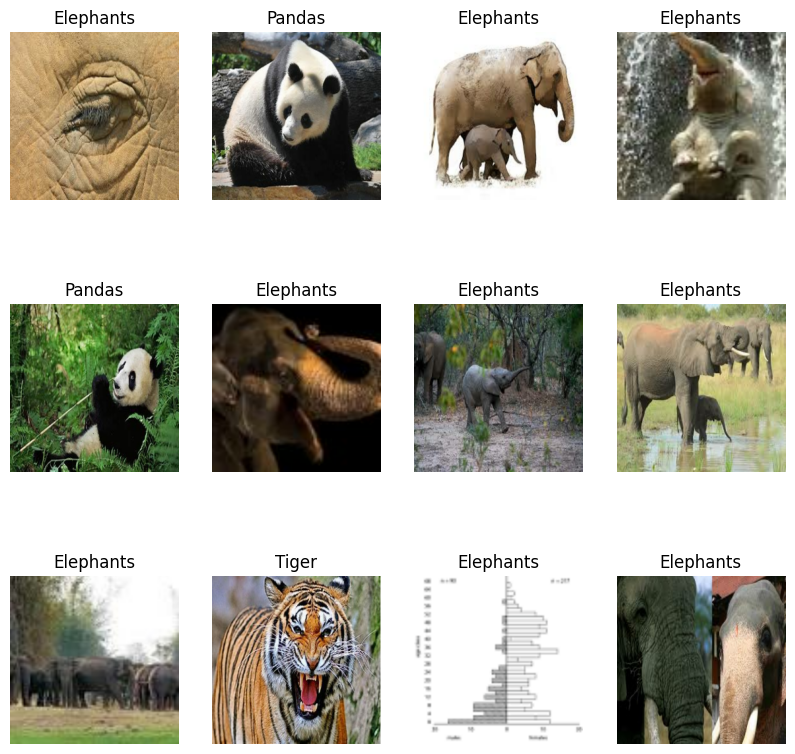

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

14

**Training Testing and Validation**

In [9]:
train_size = 0.8
len(dataset)*train_size

11.200000000000001

In [10]:
train_ds = dataset.take(54)
len(train_ds)

14

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

1.4000000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

0

### 4. **Partitioning the dataset:**

   a) The dataset is split into training, validation, and test sets using the get_dataset_partitions_tf() function.

   b) The function takes the dataset and the desired split percentages as parameters.

   c) The training set is assigned to train_ds, the validation set to val_ds, and the test set to test_ds

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ### training, testing and validation dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

11

In [18]:
len(val_ds)

1

In [19]:
len(test_ds)

2

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### 5. **Data augmentation:**

   a) Data augmentation is performed to increase the dataset's diversity and improve model generalization.

   b) The data_augmentation sequence applies random flips and rotations to the images.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
     

### 6. **Model architecture:**

   a) The model is built using the Sequential API of Keras. It consists of a series of convolutional (Conv2D) and max-pooling (MaxPooling2D) layers.

   b) The convolutional layers extract features from the input images.

   c) The final layers are a flattened layer, a dense layer with ReLU activation, and a dense layer with softmax activation for multi-class classification.

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### 7. **Model compilation:**

   a) The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy metric.

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


### 8. **Model training:**

   a) The fit() function is called to train the model on the training data. Parameters include the training data, batch size, validation data, verbosity, and the number of epochs. The training history is stored in the history variable.


In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
11/11 [==============================] - 76s 6s/step - loss: 1.0073 - accuracy: 0.7159 - val_loss: 0.7241 - val_accuracy: 0.8125
Epoch 2/20
11/11 [==============================] - 58s 5s/step - loss: 0.8532 - accuracy: 0.7727 - val_loss: 0.6724 - val_accuracy: 0.8125
Epoch 3/20
11/11 [==============================] - 57s 5s/step - loss: 0.7970 - accuracy: 0.7727 - val_loss: 0.6397 - val_accuracy: 0.8125
Epoch 4/20
11/11 [==============================] - 56s 5s/step - loss: 0.7844 - accuracy: 0.7727 - val_loss: 0.6226 - val_accuracy: 0.8125
Epoch 5/20
11/11 [==============================] - 62s 6s/step - loss: 0.7311 - accuracy: 0.7727 - val_loss: 0.5591 - val_accuracy: 0.8125
Epoch 6/20
11/11 [==============================] - 58s 5s/step - loss: 0.6726 - accuracy: 0.7727 - val_loss: 0.4058 - val_accuracy: 0.8438
Epoch 7/20
11/11 [==============================] - 57s 5s/step - loss: 0.6424 - accuracy: 0.8040 - val_loss: 0.6305 - val_accuracy: 0.8125
Epoch 8/20
11/11 [==

### 9. **Model evaluation:**

   a) The evaluate() function is used to evaluate the model's performance on the test dataset. The evaluation results (loss and accuracy) are stored in the scores variable.

In [28]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 3s 1s/step - loss: 0.3142 - accuracy: 0.9219


In [29]:
scores

[0.3141903579235077, 0.921875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 11}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

20

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0073096752166748,
 0.8532223105430603,
 0.7970489263534546,
 0.784368097782135,
 0.7311269640922546]

first image to predict
actual label: Pandas
1/1 [==============================] - 1s 1s/step
predicted label: Pandas


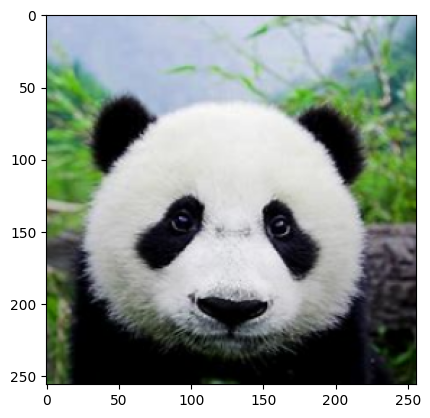

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8') #extracts the first image from the batch and converts it to a NumPy array.
    first_label = labels_batch[0].numpy() #retrieves the corresponding label for the first image in the batch.
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converts the input image (in NumPy array format) to a TensorFlow tensor
    img_array = tf.expand_dims(img_array, 0) #reshapes the tensor to have a batch dimension of 1, as the model expects input in batch format.

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### 10. **Visualizing predictions:**

   a) The code selects a batch of images from the test dataset and visualizes their actual and predicted classes using the predict() function.

1/1 [==============================] - 0s 91ms/step


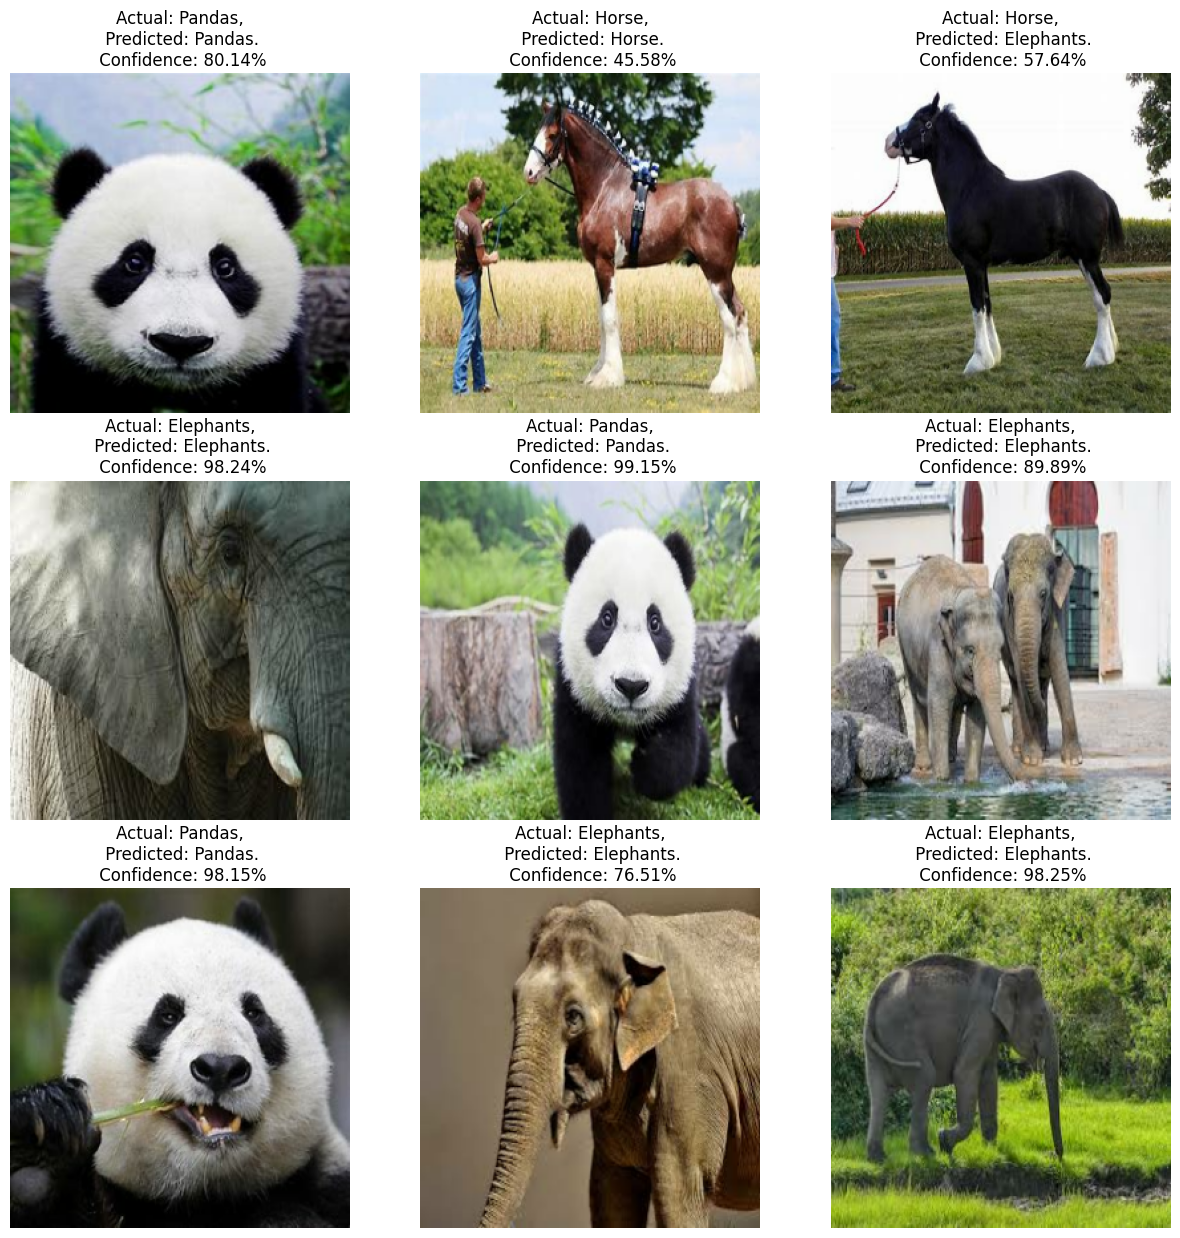

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] ### the actual class 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        ## predicted class 
        plt.axis("off")

### **Confusion Matrix** 

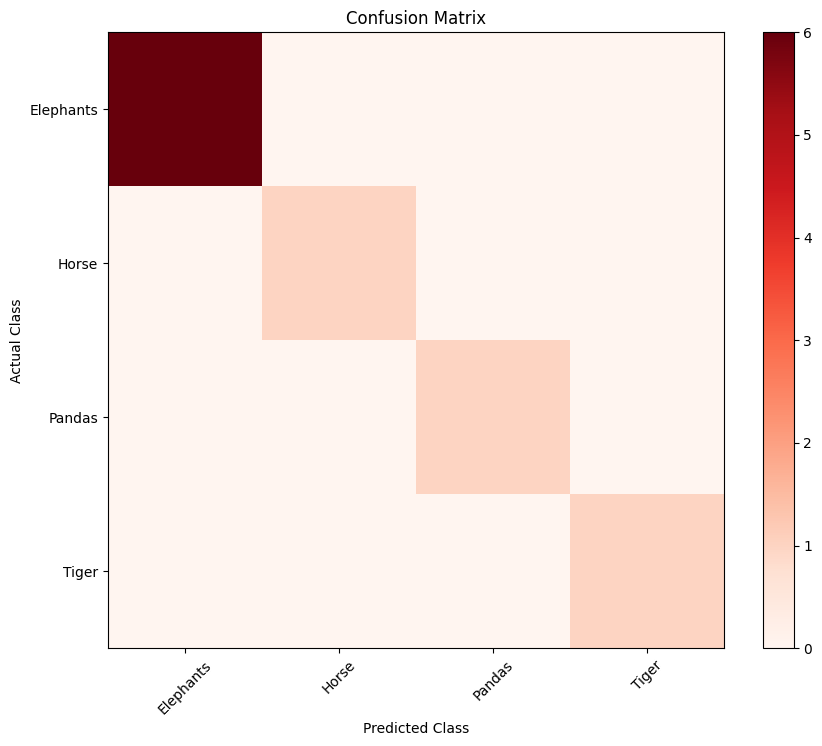

In [48]:
confusion_mtx = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(10, 8))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Reds)  # Change the color map here
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.show()

In [40]:
model.save('./models', save_format='tf')